In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import catboost as ctb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, math
warnings.filterwarnings('ignore')

from collections import Counter
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.linear_model import BayesianRidge, LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

from gplearn.genetic import SymbolicRegressor, SymbolicTransformer

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

cv_dict = {}
cv_dict['0.8904'] = 0.8669
cv_dict['0.8969'] = 0.8729
cv_dict['0.9054_0.9052'] = 0.8814
cv_dict['0.9107_0.9104'] = 0.8884
cv_dict['0.9268_0.9267'] = 0.8891
cv_dict['0.9213_0.9212'] = 0.8897
cv_dict['0.9267_0.9266'] = 0.8923
cv_dict['0.9358_0.9358'] = 0.8931
cv_dict['0.9318_0.9317'] = 0.8938
cv_dict['0.9317_0.9317'] = 0.8957
cv_dict['0.9334_0.9333'] = 0.8994
cv_dict['0.9341_0.9342'] = 0.9008
cv_dict['0.9348_0.9346'] = 0.9032
cv_dict['0.9360_0.9359'] = 0.9055
cv_dict['0.9368_0.9368'] = 0.9060
cv_dict['0.9372_0.9373'] = 0.9063
cv_dict['0.9389_0.9375'] = 0.9065
cv_dict['0.9378_0.9377'] = 0.9076
cv_dict['0.9375_0.9375'] = 0.9080

In [2]:
train = pd.read_csv('train_data.csv')
train['money_per_area'] = (train['tradeMoney'] / train['area']).astype(int)
train['room'] = [int(ht[0]) for ht in train['houseType']]

train = train[train['tradeMoney'] <= 25000]
train = train[train['region'] != 'RG00015']
train = train[train['tradeMoney'] >= 500]
train = train[(train['area'] >= 5) & (train['area'] <= 200)]
train = train[(train['totalFloor'] >= 1) & (train['totalFloor'] <= 60)]
train = train[(train['plate'] != 'BK00032') & (train['plate'] != 'BK00058')]
train.loc[(train['tradeMoney'] <= 1900) & (train['area'] >= 50), 'rentType'] = '合租'
train.loc[train['rentType'] == '--', 'rentType'] = '整租'
train.loc[train['tradeMoney'] >= 14000, 'rentType'] = '整租'
train.loc[(train['tradeMoney'] >= 10000) & (train['tradeMoney'] <= 14000) & (train['money_per_area'] >= 120), 'rentType'] = '整租'
train.loc[(train['tradeMoney'] <= 2000) & (train['room'] >= 3) & (train['rentType'] == '未知方式'), 'rentType'] = '合租'
train.loc[(train['houseType'] == '1室0厅0卫') & (train['rentType'] == '未知方式'), 'rentType'] = '整租'
#     train.loc[(train['houseType'] == '1室1厅1卫') & (train['tradeMoney'] >= 7000) & (train['rentType'] == '未知方式'), 'rentType'] = '整租'
# train.loc[(train['tradeMoney'] >= 10000) & (train['room'] <= 1), 'rentType'] = '整租'
#     train.loc[(train['tradeMoney'] >= 9000) & (train['tradeMoney'] < 10000) & (train['room'] <= 1), 'rentType'] = '整租'
train = train.drop(['money_per_area', 'room'], axis=1)
# 实验
print(train.shape)

test = pd.read_csv('test_a.csv')
test.loc[test['houseDecoration'] == '毛坯', 'rentType'] = '整租'

train['type'] = 1
test['type'] = 0
df = pd.concat([train, test], ignore_index=True)[train.columns]

(40650, 51)


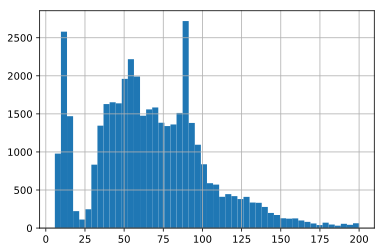

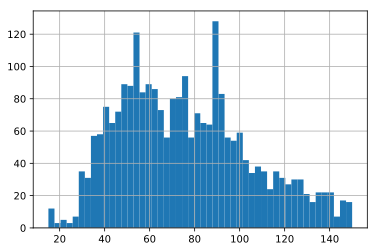

In [3]:
def ploting(col, bins=50):
    train = df[df['type'] == 1]
    test = df[df['type'] == 0]
    train[col].hist(bins=bins)
    plt.show()
    test[col].hist(bins=bins)
    
ploting('area')

In [4]:
train['rentType'].value_counts()

# 30329
# 5382
# 5201

未知方式    27420
合租       7139
整租       6091
Name: rentType, dtype: int64

In [5]:
def rentType_trans(rt):
    if rt == '未知方式':
        return 0
    elif rt == '整租':
        return 1
    elif rt == '合租':
        return 2
    else:
        return 1

df['rentType'] = df['rentType'].apply(rentType_trans)

df['room'] = [int(ht[0]) for ht in df['houseType']]
df['hall'] = [int(ht[2]) for ht in df['houseType']]
df['bath'] = [int(ht[-2]) for ht in df['houseType']]

df.loc[(df['area'] <= 50) & (df['room'] >= 3) & (df['rentType'] == 0), 'rentType'] = 2
df.loc[(df['rentType'] == 2) & (df['area'] > 50), 'area'] = df['area'] / (df['room'] + 1)

def houseFloor_trans(hf):
    if hf == '低':
        return 0
    elif hf == '中':
        return 1
    else:
        return 2

df['houseFloor'] = df['houseFloor'].apply(houseFloor_trans)

def houseToward_trans(ht):
    if ht == '暂无数据':
        return 0
    elif ht in ['南', '南北', '北']:
        return 1
    elif ht in ['东', '东西', '西']:
        return 2
    elif ht in ['西北', '东南']:
        return 3
    elif ht in ['东北', '西南']:
        return 4
    
df['houseToward'] = df['houseToward'].apply(houseToward_trans)

def houseDecoration_trans(hd):
    if hd == '其他':
        return 0
    elif hd == '毛坯':
        return 1
    elif hd == '简装':
        return 2
    else:
        return 3

df['houseDecoration'] = df['houseDecoration'].apply(houseDecoration_trans)
df.loc[(df['houseDecoration'] == 1) & (df['rentType'] == 0), 'rentType'] = 1

df['communityName'] = [int(cn[2: ]) for cn in df['communityName']]
df['region'] = [int(re[2: ]) for re in df['region']]
df['plate'] = [int(pl[2: ]) for pl in df['plate']]

df['buildYear'] = [np.nan if by == '暂无信息' else float(by) for by in df['buildYear']]
df['trade_month'] = [int(time.split('/')[1]) for time in df['tradeTime']]
df['season'] = [int(np.ceil(month / 3)) for month in df['trade_month']]

df = df.drop(['city'], axis=1)

In [6]:
df['totalRoom'] = df['room'] + df['hall'] + df['bath']
df['area_per_room'] = df['area'] / df['totalRoom']
df['floor_ratio'] = round(df['totalFloor'] * ((df['houseFloor'] * 2 + 1) / 6))
df['per_pv'] = df['pv'] / df['uv']
df['mean_pv'] = (df['pv'] + df['uv']) / 2
df['max_pv'] = np.max(df[['pv', 'uv']], axis=1)
df['min_pv'] = np.min(df[['pv', 'uv']], axis=1)
df['std_pv'] = np.std(df[['pv', 'uv']], axis=1)
df['worker_ratio'] = df['totalWorkers'] / df['residentPopulation']

In [7]:
df['room'] = [1 if rt == 2 else room for rt, room in np.array(df[['rentType', 'room']])]
df['totalRoom'] = [1 if rt == 2 else tr for rt, tr in np.array(df[['rentType', 'totalRoom']])]
# df['area'] = [area / room if rt == 2 and area >= 50 else area for rt, room, area in np.array(df[['rentType', 'room', 'area']])]

In [8]:
a = df.groupby(['plate', 'rentType']).mean().reset_index()[['plate', 'rentType', 'tradeMoney']].sort_values('tradeMoney', ascending=False).rename(columns={'tradeMoney': 'plate_mean'})
b = df.groupby(['region', 'rentType']).mean().reset_index()[['region', 'rentType', 'tradeMoney']].sort_values('tradeMoney', ascending=False).rename(columns={'tradeMoney': 'region_mean'})
c = df.groupby(['plate', 'rentType']).median().reset_index()[['plate', 'rentType', 'tradeMoney']].sort_values('tradeMoney', ascending=False).rename(columns={'tradeMoney': 'plate_median'})
d = df.groupby(['region', 'rentType']).median().reset_index()[['region', 'rentType', 'tradeMoney']].sort_values('tradeMoney', ascending=False).rename(columns={'tradeMoney': 'region_median'})

df = df.merge(a, how='left', on=['plate', 'rentType'])
df = df.merge(b, how='left', on=['region', 'rentType'])
df = df.merge(c, how='left', on=['plate', 'rentType'])
df = df.merge(d, how='left', on=['region', 'rentType'])

In [9]:
a = df.groupby(['region']).size().reset_index().rename(columns={0: 'region_num'})
df = df.merge(a, how='left', on=['region'])
a = df.groupby(['plate']).size().reset_index().rename(columns={0: 'plate_num'})
df = df.merge(a, how='left', on=['plate'])
a = df.groupby(['communityName']).size().reset_index().rename(columns={0: 'community_num'})
df = df.merge(a, how='left', on=['communityName'])
a = df[['region', 'plate']].groupby(['region']).apply(lambda x: x['plate'].nunique()).reset_index().rename(columns={0: 'plate_contain'})
df = df.merge(a, how='left', on=['region'])
a = df.groupby('plate').apply(lambda x: x['communityName'].nunique()).reset_index().rename(columns={0: 'community_contain'})
df = df.merge(a, how='left', on=['plate'])

In [10]:
a = df.groupby('plate').mean().reset_index()[['plate', 'totalFloor']].rename(columns={'totalFloor': 'plate_mean_floor'})
df = df.merge(a, how='left', on=['plate'])
a = df.groupby('plate').median().reset_index()[['plate', 'totalFloor']].rename(columns={'totalFloor': 'plate_median_floor'})
df = df.merge(a, how='left', on=['plate'])
a = df.groupby('plate').mean().reset_index()[['plate', 'area']].rename(columns={'area': 'plate_mean_area'})
df = df.merge(a, how='left', on=['plate'])
a = df.groupby('plate').median().reset_index()[['plate', 'area']].rename(columns={'area': 'plate_median_area'})
df = df.merge(a, how='left', on=['plate'])

In [11]:
df['room_ratio'] = df['room'] / df['totalRoom']
df['hall_ratio'] = df['hall'] / df['totalRoom']
df['bath_ratio'] = df['bath'] / df['totalRoom']
df['room-bath'] = df['room'] - df['bath']

df['max_type'] = np.argmax(np.array(df[['room', 'hall', 'bath']]), axis=1)

df['trade_avg'] = df['totalTradeArea'] / (df['tradeSecNum'] + 1)

df['originWorkers'] = df['totalWorkers'] - df['newWorkers']

# df['feature2'] = df['plate_mean'] / df['region_mean']

df['area_part'] = pd.qcut(df['area'], q=6, labels=[0, 1, 2, 3, 4, 5])

df['tf_part'] = pd.qcut(df['totalFloor'], q=8, duplicates='drop', labels=[i for i in range(6)])

In [12]:
# plate, room, area, totalRoom

a = df.groupby(['communityName']).apply(lambda x: x['totalRoom'].tolist()).reset_index()
a['mean_totalRoom'] = [np.mean(i) for i in a[0]]
a['median_totalRoom'] = [np.median(i) for i in a[0]]
a = a.drop(0, axis=1)
df = df.merge(a, how='left', on=['communityName'])

a = df.groupby(['communityName']).apply(lambda x: x['room'].tolist()).reset_index()
a['mean_room'] = [np.mean(i) for i in a[0]]
a['median_room'] = [np.median(i) for i in a[0]]
a = a.drop(0, axis=1)
df = df.merge(a, how='left', on=['communityName'])

a = df.groupby(['plate', 'area_part']).apply(lambda x: x['totalRoom'].tolist()).reset_index()
a['plate_mean_totalRoom'] = [np.mean(i) for i in a[0]]
a['plate_median_totalRoom'] = [np.median(i) for i in a[0]]
a = a.drop(0, axis=1)
df = df.merge(a, how='left', on=['plate', 'area_part'])

a = df.groupby(['plate', 'area_part']).apply(lambda x: x['room'].tolist()).reset_index()
a['plate_mean_room'] = [np.mean(i) for i in a[0]]
a['plate_median_room'] = [np.median(i) for i in a[0]]
a = a.drop(0, axis=1)
df = df.merge(a, how='left', on=['plate', 'area_part'])

In [13]:
a = df.groupby(['area_part', 'rentType']).apply(lambda x: x['tradeMoney'].tolist()).reset_index()
a['area_type_mean'] = [np.nanmean(i) for i in a[0]]
a['area_type_median'] = [np.nanmedian(i) for i in a[0]]
a['area_type_max'] = [np.nanmax(i) for i in a[0]]
a['area_type_min'] = [np.nanmin(i) for i in a[0]]
a['area_type_num'] = [len(i) for i in a[0]]
a = a.drop(0, axis=1)
df = df.merge(a, how='left', on=['area_part', 'rentType'])

In [14]:
for col in ['subwayStationNum', 'busStationNum', 'interSchoolNum', 'schoolNum', 'privateSchoolNum', 'hospitalNum',
       'drugStoreNum', 'gymNum', 'bankNum', 'shopNum', 'parkNum', 'mallNum', 'superMarketNum']:
    df['per_' + col] = df['residentPopulation'] / (df[col] + 1)
    df['workers_per_' + col] = df['totalWorkers'] / (df[col] + 1)

df['sub_div_bus'] = df['per_subwayStationNum'] / df['per_busStationNum']
df['sub_minus_bus'] = df['per_subwayStationNum'] - df['per_busStationNum']
df['sub_bus_ratio'] = df['sub_minus_bus'] / df['per_subwayStationNum']

df['workers_sub_div_bus'] = df['workers_per_subwayStationNum'] / df['workers_per_busStationNum']
df['workers_sub_minus_bus'] = df['workers_per_subwayStationNum'] - df['workers_per_busStationNum']
df['workers_sub_bus_ratio'] = df['workers_sub_minus_bus'] / df['workers_per_subwayStationNum']

count_feature_list = []
for i in ['totalFloor', 'tf_part']:
    count_feature_list.append('count_' + i)
    df['count_' + i] = df[i].map(df[i].value_counts())
    
a = df.groupby(['count_tf_part', 'count_totalFloor']).apply(lambda x: x['buildYear'].tolist()).reset_index()
a['is_nan'] = [np.sign(np.mean(i)) for i in a[0]]
a['is_nan'].fillna(0, inplace=True)
a['is_nan'] = 1 - a['is_nan']
a = a[a['is_nan'] == 1]
a['buildYear'] = [int(np.nanmean(i)) for i in a[0]]
a = a.drop([0, 'is_nan'], axis=1)

b = df[df['buildYear'].isna()][['count_tf_part', 'count_totalFloor']]
b_index = b.index
b = b.merge(a, how='left', on=['count_tf_part', 'count_totalFloor'])
b.index = b_index
df['buildYear'].fillna(b['buildYear'], axis='index', inplace=True)
df['used_year'] = 2018 - df['buildYear']
df['area-year'] = df['area'] / (df['used_year'] + 1)
    
for i in ['buildYear', 'room', 'hall', 'bath', 'area_part']:
    count_feature_list.append('count_' + i)
    df['count_' + i] = df[i].map(df[i].value_counts())

df['drug_per_hosp'] = df['drugStoreNum'] / (df['hospitalNum'] + 1)
df['supermarket_ratio'] = df['superMarketNum'] / df['shopNum']
df['new_with_subway'] = (df['subwayStationNum'] + 1) / (df['used_year']  + 1)
df['new_with_bus'] = df['busStationNum'] / (df['used_year'] + 1)
df['private_school_ratio'] = df['interSchoolNum'] / (df['privateSchoolNum'] + 1)
df['total_school'] = df['schoolNum'] + df['privateSchoolNum']

In [15]:
# rentType
a = df.groupby(['communityName']).apply(lambda x: x['rentType'].tolist()).reset_index()
a['0num'] = [single.count(0) for single in a[0]]
a['1num'] = [single.count(1) for single in a[0]]
a['2num'] = [single.count(2) for single in a[0]]
a['0ratio'] = a['0num'] / np.sum(a[['0num', '1num', '2num']], axis=1)
a['1ratio'] = a['1num'] / np.sum(a[['0num', '1num', '2num']], axis=1)
a['2ratio'] = a['2num'] / np.sum(a[['0num', '1num', '2num']], axis=1)
a = a[['communityName', '0num', '1num', '2num', '0ratio', '1ratio', '2ratio']]
a['most_type'] = np.argmax(a[['0num', '1num', '2num']].values, axis=1)
df = df.merge(a, how='left', on=['communityName'])

# -------------------------------------------------------------------------------------

# a = df.groupby(['plate']).apply(lambda x: x['rentType'].tolist()).reset_index()
# a['0pnum'] = [single.count(0) for single in a[0]]
# a['1pnum'] = [single.count(1) for single in a[0]]
# a['2pnum'] = [single.count(2) for single in a[0]]
# a['0pratio'] = a['0pnum'] / np.sum(a[['0pnum', '1pnum', '2pnum']], axis=1)
# a['1pratio'] = a['1pnum'] / np.sum(a[['0pnum', '1pnum', '2pnum']], axis=1)
# a['2pratio'] = a['2pnum'] / np.sum(a[['0pnum', '1pnum', '2pnum']], axis=1)
# a = a[['plate', '0pnum', '1pnum', '2pnum', '0pratio', '1pratio', '2pratio']]
# df = df.merge(a, how='left', on=['plate'])

In [16]:
# area
a = df.groupby(['communityName']).apply(lambda x: x['area'].tolist()).reset_index()
a['comm_area_len'] = [len(a) for a in a[0]]
a = a.merge(df.groupby(['communityName']).apply(lambda x: x['area'].nunique()).reset_index().rename(columns={0: 'comm_area_kind'}), how='left', on=['communityName'])
a['comm_mean_area'] = [np.mean(i) for i in a[0]]
a['comm_median_area'] = [np.median(i) for i in a[0]]
a['comm_max_area'] = [np.max(i) for i in a[0]]
a['comm_min_area'] = [np.min(i) for i in a[0]]
a['comm_std_area'] = [np.std(i) for i in a[0]]
a['comm_area_common_num'] = a['comm_area_len'] - a['comm_area_kind']
a['comm_area_unique_ratio'] = a['comm_area_kind'] / a['comm_area_len']
a['comm_area_common_ratio'] = 1 - a['comm_area_kind'] / a['comm_area_len']
a = a.drop(0, axis=1)
df = df.merge(a, how='left', on=['communityName'])

# -----------------------------------------------------------------------------------------

# a = df.groupby(['plate']).apply(lambda x: x['area'].tolist()).reset_index()
# a['plate_area_len'] = [len(a) for a in a[0]]
# a = a.merge(df.groupby(['plate']).apply(lambda x: x['area'].nunique()).reset_index().rename(columns={0: 'plate_area_kind'}), how='left', on=['plate'])
# # a['plate_mean_area'] = [np.mean(i) for i in a[0]]
# # a['plate_median_area'] = [np.median(i) for i in a[0]]
# a['plate_max_area'] = [np.max(i) for i in a[0]]
# a['plate_min_area'] = [np.min(i) for i in a[0]]
# a['plate_std_area'] = [np.std(i) for i in a[0]]
# a['plate_area_common_num'] = a['plate_area_len'] - a['plate_area_kind']
# a['plate_area_unique_ratio'] = a['plate_area_kind'] / a['plate_area_len']
# a['plate_area_common_ratio'] = 1 - a['plate_area_kind'] / a['plate_area_len']
# a = a.drop(0, axis=1)
# df = df.merge(a, how='left', on=['plate'])

In [17]:
# houseDecoration
a = df.groupby('communityName').apply(lambda x: x['houseDecoration'].tolist()).reset_index()
a['comm_deco_len'] = [len(i) for i in a[0]]
a = a.merge(df.groupby(['communityName']).apply(lambda x: x['houseDecoration'].nunique()).reset_index().rename(columns={0: 'comm_deco_kind'}), how='left', on=['communityName'])
a['0deco'] = [single.count(0) for single in a[0]]
a['1deco'] = [single.count(1) for single in a[0]]
a['2deco'] = [single.count(2) for single in a[0]]
a['3deco'] = [single.count(3) for single in a[0]]
a['0deco_ratio'] = a['0deco'] / np.sum(a[['0deco', '1deco', '2deco', '3deco']], axis=1)
a['1deco_ratio'] = a['1deco'] / np.sum(a[['0deco', '1deco', '2deco', '3deco']], axis=1)
a['2deco_ratio'] = a['2deco'] / np.sum(a[['0deco', '1deco', '2deco', '3deco']], axis=1)
a['3deco_ratio'] = a['3deco'] / np.sum(a[['0deco', '1deco', '2deco', '3deco']], axis=1)
a = a.drop(0, axis=1)
df = df.merge(a, how='left', on=['communityName'])

# --------------------------------------------------------------------------------------------

# a = df.groupby('plate').apply(lambda x: x['houseDecoration'].tolist()).reset_index()
# a['plate_pdeco_len'] = [len(i) for i in a[0]]
# a = a.merge(df.groupby(['plate']).apply(lambda x: x['houseDecoration'].nunique()).reset_index().rename(columns={0: 'plate_pdeco_kind'}), how='left', on=['plate'])
# a['0pdeco'] = [single.count(0) for single in a[0]]
# a['1pdeco'] = [single.count(1) for single in a[0]]
# a['2pdeco'] = [single.count(2) for single in a[0]]
# a['3pdeco'] = [single.count(3) for single in a[0]]
# a['0pdeco_ratio'] = a['0pdeco'] / np.sum(a[['0pdeco', '1pdeco', '2pdeco', '3pdeco']], axis=1)
# a['1pdeco_ratio'] = a['1pdeco'] / np.sum(a[['0pdeco', '1pdeco', '2pdeco', '3pdeco']], axis=1)
# a['2pdeco_ratio'] = a['2pdeco'] / np.sum(a[['0pdeco', '1pdeco', '2pdeco', '3pdeco']], axis=1)
# a['3pdeco_ratio'] = a['3pdeco'] / np.sum(a[['0pdeco', '1pdeco', '2pdeco', '3pdeco']], axis=1)
# a = a.drop(0, axis=1)
# df = df.merge(a, how='left', on=['plate'])

In [18]:
# houseToward
a = df.groupby('communityName').apply(lambda x: x['houseToward'].tolist()).reset_index()
a = a.merge(df.groupby(['communityName']).apply(lambda x: x['houseToward'].nunique()).reset_index().rename(columns={0: 'comm_toward_kind'}), how='left', on=['communityName'])
a['to0'] = [i.count(0) for i in a[0]]
a['to1'] = [i.count(1) for i in a[0]]
a['to2'] = [i.count(2) for i in a[0]]
a['to3'] = [i.count(3) for i in a[0]]
a['to4'] = [i.count(4) for i in a[0]]
a['to0_ratio'] = a['to0'] / np.sum(a[['to0', 'to1', 'to2', 'to3', 'to4']], axis=1)
a['to1_ratio'] = a['to1'] / np.sum(a[['to0', 'to1', 'to2', 'to3', 'to4']], axis=1)
a['to2_ratio'] = a['to2'] / np.sum(a[['to0', 'to1', 'to2', 'to3', 'to4']], axis=1)
a['to3_ratio'] = a['to3'] / np.sum(a[['to0', 'to1', 'to2', 'to3', 'to4']], axis=1)
a['to4_ratio'] = a['to4'] / np.sum(a[['to0', 'to1', 'to2', 'to3', 'to4']], axis=1)
a['max_toward_type'] = np.argmax(a[['to0', 'to1', 'to2', 'to3', 'to4']].values, axis=1)
a['max_toward_ratio'] = np.max(a[['to0', 'to1', 'to2', 'to3', 'to4']], axis=1) / np.sum(a[['to0', 'to1', 'to2', 'to3', 'to4']], axis=1)
a = a.drop(0, axis=1)
df = df.merge(a, how='left', on=['communityName'])

# ---------------------------------------------------------------------------------------------------------------------------------------

# a = df.groupby('plate').apply(lambda x: x['houseToward'].tolist()).reset_index()
# a = a.merge(df.groupby(['plate']).apply(lambda x: x['houseToward'].nunique()).reset_index().rename(columns={0: 'plate_ptoward_kind'}), how='left', on=['plate'])
# a['pto0'] = [i.count(0) for i in a[0]]
# a['pto1'] = [i.count(1) for i in a[0]]
# a['pto2'] = [i.count(2) for i in a[0]]
# a['pto3'] = [i.count(3) for i in a[0]]
# a['pto4'] = [i.count(4) for i in a[0]]
# a['pto0_ratio'] = a['pto0'] / np.sum(a[['pto0', 'pto1', 'pto2', 'pto3', 'pto4']], axis=1)
# a['pto1_ratio'] = a['pto1'] / np.sum(a[['pto0', 'pto1', 'pto2', 'pto3', 'pto4']], axis=1)
# a['pto2_ratio'] = a['pto2'] / np.sum(a[['pto0', 'pto1', 'pto2', 'pto3', 'pto4']], axis=1)
# a['pto3_ratio'] = a['pto3'] / np.sum(a[['pto0', 'pto1', 'pto2', 'pto3', 'pto4']], axis=1)
# a['pto4_ratio'] = a['pto4'] / np.sum(a[['pto0', 'pto1', 'pto2', 'pto3', 'pto4']], axis=1)
# a['max_ptoward_type'] = np.argmax(a[['pto0', 'pto1', 'pto2', 'pto3', 'pto4']].values, axis=1)
# a['max_ptoward_ratio'] = np.max(a[['pto0', 'pto1', 'pto2', 'pto3', 'pto4']], axis=1) / np.sum(a[['pto0', 'pto1', 'pto2', 'pto3', 'pto4']], axis=1)
# a = a.drop(0, axis=1)
# df = df.merge(a, how='left', on=['plate'])

In [19]:
# totalFloor
a = df.groupby('communityName').apply(lambda x: x['totalFloor'].tolist()).reset_index()
a = a.merge(df.groupby(['communityName']).apply(lambda x: x['totalFloor'].nunique()).reset_index().rename(columns={0: 'comm_totalFloor_unique'}), how='left', on=['communityName'])
a['comm_totalFloor_len'] = [len(i) for i in a[0]]
a['majority'] = [np.argmax(np.bincount(i)) for i in a[0]]
a['majority_num'] = [np.max(np.bincount(i)) for i in a[0]]
a['majority_ratio'] = [np.max(np.bincount(i)) / len(i) for i in a[0]]
a['totalFloor_std'] = [np.std(i) for i in a[0]]
a = a.drop(0, axis=1)
df = df.merge(a, how='left', on=['communityName'])

# ---------------------------------------------------------------------------------------------------

# a = df.groupby('plate').apply(lambda x: x['totalFloor'].tolist()).reset_index()
# a = a.merge(df.groupby(['plate']).apply(lambda x: x['totalFloor'].nunique()).reset_index().rename(columns={0: 'plate_totalFloor_unique'}), how='left', on=['plate'])
# a['plate_totalFloor_len'] = [len(i) for i in a[0]]
# a['pmajority'] = [np.argmax(np.bincount(i)) for i in a[0]]
# a['pmajority_num'] = [np.max(np.bincount(i)) for i in a[0]]
# a['pmajority_ratio'] = [np.max(np.bincount(i)) / len(i) for i in a[0]]
# a['ptotalFloor_std'] = [np.std(i) for i in a[0]]
# a = a.drop(0, axis=1)
# df = df.merge(a, how='left', on=['plate'])

In [20]:
a = df.groupby('plate').apply(lambda x: x['buildYear'].tolist()).reset_index()
a['mean_year'] = [np.nanmean(i) for i in a[0]]
a['most_year'] = [Counter(i).most_common()[0][0] for i in a[0]]
a['most_count'] = [i.count(most) for i, most in a[[0, 'most_year']].values]
a['most_ratio'] = [mc / len(i) for mc, i in a[['most_count', 0]].values]
a = a.drop(0, axis=1)
df = df.merge(a, how='left', on=['plate'])

+ 越老越贵，越小越贵
+ 岗位密集区租金更高
+ 上班族越多，附近租金越贵
+ 地铁相比于公交来说，对多数需要远距离通勤的租客来说是首要考虑的交通工具，因此对房租的影响也最为显著
+ 每平方米月租金：租金/平方米

In [21]:
train = df[df['type'] == 1]
train['money_per_area'] = train['tradeMoney'] / train['area']
a = train.groupby('communityName').mean().reset_index()[['communityName', 'money_per_area']]
a['money_per_area'] = [int(i + (10 - i % 10)) if i % 10 >= 5 else int(i - i % 10) for i in a['money_per_area']]
df = df.merge(a, how='left', on=['communityName'])

In [22]:
a = df.groupby('plate').apply(lambda x: x['money_per_area'].tolist()).reset_index()
a['mean_money'] = [np.nanmean(i) for i in a[0]]
a['median_money'] = [np.nanmedian(i) for i in a[0]]
a['std_money'] = [np.nanstd(i) for i in a[0]]
a = a.drop(0, axis=1)
df = df.merge(a, how='left', on=['plate'])

# a = df.groupby(['plate', 'rentType']).apply(lambda x: x['money_per_area'].tolist()).reset_index()
# a['plate_type_mean_money'] = [np.mean(i) for i in a[0]]
# a['plate_type_median_money'] = [np.median(i) for i in a[0]]
# a = a.drop(0, axis=1)
# df = df.merge(a, how='left', on=['plate', 'rentType'])

a = df.groupby(['region', 'rentType']).apply(lambda x: x['money_per_area'].tolist()).reset_index()
a['region_type_mean_money'] = [np.nanmean(i) for i in a[0]]
a['region_type_median_money'] = [np.nanmedian(i) for i in a[0]]
a = a.drop(0, axis=1)
df = df.merge(a, how='left', on=['region', 'rentType'])

In [23]:
a = df.groupby(['area_part', 'rentType']).apply(lambda x: x['money_per_area'].tolist()).reset_index()
a['mean_area_part_money'] = [np.nanmean(i) for i in a[0]]
a['median_area_part_money'] = [np.nanmedian(i) for i in a[0]]
a['std_area_part_money'] = [np.nanstd(i) for i in a[0]]
a['max_area_part_money'] = [np.nanmax(i) for i in a[0]]
a['min_area_part_money'] = [np.nanmin(i) for i in a[0]]
a = a.drop(0, axis=1)
df = df.merge(a, how='left', on=['area_part', 'rentType'])

In [24]:
# df['money_for_room'] = df['area_per_room'] * df['money_per_area'] # 0.9449 corr: 0.684
df['money_for_room'] = df['area_per_room'] * df['mean_money'] # 0.9372 corr: 0.681

In [25]:
def ID_scaled():
    X = df['ID']
    X_scaled = (X-X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    df['ID'] = X_scaled
    
# ID_scaled()

In [26]:
a = df.groupby('communityName').apply(lambda x: x['ID'].tolist()).reset_index()
a['id_std'] = [np.std(i) for i in a[0]]
a['id_mean'] = [np.mean(i) for i in a[0]]
a['id_median'] = [np.median(i) for i in a[0]]
a = a.drop(0, axis=1)
df = df.merge(a, how='left', on=['communityName'])

In [27]:
a = df.groupby(['plate', 'rentType']).apply(lambda x: x['ID'].tolist()).reset_index()
a['plate_type_id_std'] = [np.std(i) for i in a[0]]
a['plate_type_id_mean'] = [np.mean(i) for i in a[0]]
a['plate_type_id_median'] = [np.median(i) for i in a[0]]
a = a.drop(0, axis=1)
df = df.merge(a, how='left', on=['plate', 'rentType'])

In [28]:
df['trade_sec_avg_area'] = df['totalTradeArea'] / (df['tradeSecNum'] + 1)
df['trade_sec_avg_money'] = df['totalTradeMoney'] / (df['tradeSecNum'] + 1)
df['total_new_num'] = df['tradeNewNum'] + df['remainNewNum']
df['new_ratio'] = df['tradeNewNum'] / (df['total_new_num'] + 1)
df['remain_ratio'] = df['remainNewNum'] / (df['total_new_num'] + 1)
df['new_over_remain'] = df['tradeNewNum'] / (df['remainNewNum'] + 1)
df['is_supply_new'] = [1 if sup > 0 else 0 for sup in df['supplyNewNum']]
df['trade_new_avg_area'] = df['totalNewTradeArea'] / (df['tradeNewNum'] + 1)
df['trade_new_avg_money'] = df['totalNewTradeMoney'] / (df['tradeNewNum'] + 1)

df['trade_land_ratio'] = [trade / (supply + 1) for trade, supply in df[['tradeLandNum', 'supplyLandNum']].values]

df['uv_ratio'] = [uv / nw if nw > 0 else 0 for uv, nw in df[['uv', 'newWorkers']].values]

In [29]:
num_cols = ['subwayStationNum', 'busStationNum', 'interSchoolNum', 'schoolNum', 'privateSchoolNum', 'hospitalNum',
       'drugStoreNum', 'gymNum', 'bankNum', 'shopNum', 'parkNum', 'mallNum', 'superMarketNum']

for col in num_cols:
    df[col+'_ratio'] = df[col] / np.sum(df[num_cols], axis=1)

In [31]:
df.sample(10)

,ID,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,region,plate,buildYear,saleSecHouseNum,subwayStationNum,busStationNum,interSchoolNum,schoolNum,privateSchoolNum,hospitalNum,drugStoreNum,gymNum,bankNum,shopNum,parkNum,mallNum,superMarketNum,totalTradeMoney,totalTradeArea,tradeMeanPrice,tradeSecNum,totalNewTradeMoney,totalNewTradeArea,tradeNewMeanPrice,tradeNewNum,remainNewNum,supplyNewNum,supplyLandNum,supplyLandArea,tradeLandNum,tradeLandArea,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney,type,room,hall,bath,trade_month,season,totalRoom,area_per_room,floor_ratio,per_pv,mean_pv,max_pv,min_pv,std_pv,worker_ratio,plate_mean,region_mean,plate_median,region_median,region_num,plate_num,community_num,plate_contain,community_contain,plate_mean_floor,plate_median_floor,plate_mean_area,plate_median_area,room_ratio,hall_ratio,bath_ratio,room-bath,max_type,trade_avg,originWorkers,area_part,tf_part,mean_totalRoom,median_totalRoom,mean_room,median_room,plate_mean_totalRoom,plate_median_totalRoom,plate_mean_room,plate_median_room,area_type_mean,area_type_median,area_type_max,area_type_min,area_type_num,per_subwayStationNum,workers_per_subwayStationNum,per_busStationNum,workers_per_busStationNum,per_interSchoolNum,workers_per_interSchoolNum,per_schoolNum,workers_per_schoolNum,per_privateSchoolNum,workers_per_privateSchoolNum,per_hospitalNum,workers_per_hospitalNum,per_drugStoreNum,workers_per_drugStoreNum,per_gymNum,workers_per_gymNum,per_bankNum,workers_per_bankNum,per_shopNum,workers_per_shopNum,per_parkNum,workers_per_parkNum,per_mallNum,workers_per_mallNum,per_superMarketNum,workers_per_superMarketNum,sub_div_bus,sub_minus_bus,sub_bus_ratio,workers_sub_div_bus,workers_sub_minus_bus,workers_sub_bus_ratio,count_totalFloor,count_tf_part,used_year,area-year,count_buildYear,count_room,count_hall,count_bath,count_area_part,drug_per_hosp,supermarket_ratio,new_with_subway,new_with_bus,private_school_ratio,total_school,0num,1num,2num,0ratio,1ratio,2ratio,most_type,comm_area_len,comm_area_kind,comm_mean_area,comm_median_area,comm_max_area,comm_min_area,comm_std_area,comm_area_common_num,comm_area_unique_ratio,comm_area_common_ratio,comm_deco_len,comm_deco_kind,0deco,1deco,2deco,3deco,0deco_ratio,1deco_ratio,2deco_ratio,3deco_ratio,comm_toward_kind,to0,to1,to2,to3,to4,to0_ratio,to1_ratio,to2_ratio,to3_ratio,to4_ratio,max_toward_type,max_toward_ratio,comm_totalFloor_unique,comm_totalFloor_len,majority,majority_num,majority_ratio,totalFloor_std,mean_year,most_year,most_count,most_ratio,money_per_area,mean_money,median_money,std_money,region_type_mean_money,region_type_median_money,mean_area_part_money,median_area_part_money,std_area_part_money,max_area_part_money,min_area_part_money,money_for_room,id_std,id_mean,id_median,plate_type_id_std,plate_type_id_mean,plate_type_id_median,trade_sec_avg_area,trade_sec_avg_money,total_new_num,new_ratio,remain_ratio,new_over_remain,is_supply_new,trade_new_avg_area,trade_new_avg_money,trade_land_ratio,uv_ratio,subwayStationNum_ratio,busStationNum_ratio,interSchoolNum_ratio,schoolNum_ratio,privateSchoolNum_ratio,hospitalNum_ratio,drugStoreNum_ratio,gymNum_ratio,bankNum_ratio,shopNum_ratio,parkNum_ratio,mallNum_ratio,superMarketNum_ratio
2858,100065447,60.02,0,2室1厅1卫,0,6,1,0,1819,5,33,1993.0,0,1,96,0,53,15,1,36,34,52,162,8,6,47,742490000,18218.83,40753.98914,214,0,0,0.000000,0,17,0,0,0.0,0,0.00,0,0.000000,50134,0,226469,59451.0,7555.0,0,2018/6/8,3500.0,1,2,1,1,6,2,4,15.005000,1.0,7.869093,33503.0,59451.0,7555.0,25948.0,0.221372,4888.612193,4964.097963,4500.0,4400.0,5907,1914,16,8,127,10.095611,7.0,74.085618,69.000,0.500000,0.250000,0.250000,1,0,84.738744,50134,2,0,3.625000,4.0,1.750000,2.0,3.372760,3.0,1.408602,1.0,4025.844638,3900.0,9900.0,1000.0,6069,113234.500000,25067.000000,2334.731959,516.845361,226469.000000,50134.000000,4193.870370,928.407407,14154.312500,3133.375000,113234.500000,25067.000000,6120.783784,13

In [32]:
df.columns[230: ]

Index(['privateSchoolNum_ratio', 'hospitalNum_ratio', 'drugStoreNum_ratio',
       'gymNum_ratio', 'bankNum_ratio', 'shopNum_ratio', 'parkNum_ratio',
       'mallNum_ratio', 'superMarketNum_ratio'],
      dtype='object')

In [33]:
train_cols = ['ID', 'area', 'rentType', 'houseFloor', 'totalFloor', 'houseToward',
       'houseDecoration', 'communityName', 'region', 'plate', 'buildYear',
       'saleSecHouseNum', 'subwayStationNum', 'busStationNum',
       'interSchoolNum', 'schoolNum', 'privateSchoolNum', 'hospitalNum',
       'drugStoreNum', 'gymNum', 'bankNum', 'shopNum', 'parkNum', 'mallNum',
       'superMarketNum', 'totalTradeMoney', 'totalTradeArea', 'tradeMeanPrice',
       'tradeSecNum', 'totalNewTradeMoney', 'totalNewTradeArea',
       'tradeNewMeanPrice', 'tradeNewNum', 'remainNewNum', 'supplyNewNum',
       'supplyLandNum', 'supplyLandArea', 'tradeLandArea',
       'landTotalPrice', 'landMeanPrice', 'totalWorkers', 'newWorkers',
       'residentPopulation', 'pv', 'uv', 'lookNum', 'room', 'hall', 'bath', 'used_year', 'totalRoom',
       'area_per_room', 'floor_ratio', 'per_pv', 'mean_pv', 'max_pv', 'min_pv',
       'std_pv', 'worker_ratio', 'region_num', 'plate_num', 'community_num',
       'plate_contain', 'community_contain', 'area_type_mean', 'area_type_num', 'area_type_median', 'area_type_max', 'area_type_min', 
       'plate_mean_floor', 'plate_median_floor', 'plate_mean_area',
       'plate_median_area', 'room_ratio', 'hall_ratio', 'bath_ratio', 'room-bath', 'max_type', 'trade_avg',
       'originWorkers', 'area_part', 'tf_part', 'mean_totalRoom', 'median_totalRoom',
       'mean_room', 'median_room', 'plate_mean_totalRoom',
       'plate_median_totalRoom', 'plate_mean_room', 'plate_median_room',
       'drug_per_hosp', 'supermarket_ratio',
       'new_with_subway', 'new_with_bus', 'private_school_ratio',
       'total_school', 'per_subwayStationNum', 'workers_per_subwayStationNum',
       'per_busStationNum', 'workers_per_busStationNum', 'per_interSchoolNum',
       'workers_per_interSchoolNum', 'per_schoolNum', 'workers_per_schoolNum',
       'per_privateSchoolNum', 'workers_per_privateSchoolNum',
       'per_hospitalNum', 'workers_per_hospitalNum', 'per_drugStoreNum',
       'workers_per_drugStoreNum', 'per_gymNum', 'workers_per_gymNum',
       'per_bankNum', 'workers_per_bankNum', 'per_shopNum', 'workers_per_shopNum',
       'per_parkNum', 'workers_per_parkNum', 'per_mallNum',
       'workers_per_mallNum', 'per_superMarketNum',
       'workers_per_superMarketNum', 'sub_div_bus',
       'sub_minus_bus', 'sub_bus_ratio', 'workers_sub_div_bus',
       'workers_sub_minus_bus', 'workers_sub_bus_ratio', 'count_totalFloor',
       'count_tf_part', 'area-year', 'count_buildYear',
       'count_room', 'count_hall', 'count_bath', 'count_area_part',
       '0num', '1num', '2num',
       '0ratio', '1ratio', '2ratio', 'most_type', 'comm_area_len', 'comm_area_kind',
       'comm_mean_area', 'comm_median_area', 'comm_max_area', 'comm_min_area',
       'comm_std_area', 'comm_area_common_num', 'comm_area_unique_ratio',
       'comm_area_common_ratio', 'comm_deco_len', 'comm_deco_kind', '0deco',
       '1deco', '2deco', '3deco', '0deco_ratio', '1deco_ratio', '2deco_ratio',
       '3deco_ratio', 'comm_toward_kind', 'to0', 'to1', 'to2', 'to3', 'to4',
       'to0_ratio', 'to1_ratio', 'to2_ratio', 'to3_ratio', 'to4_ratio',
       'max_toward_type', 'max_toward_ratio', 'comm_totalFloor_unique',
       'comm_totalFloor_len', 'majority', 'majority_num', 'majority_ratio',
       'totalFloor_std', 'mean_year', 'most_year', 'most_count', 'most_ratio',
       'mean_money', 'median_money', 'std_money',
       'region_type_mean_money', 'region_type_median_money', 'id_std', 'max_area_part_money', 'min_area_part_money', 'id_mean',
       'id_median', 'plate_type_id_std', 'plate_type_id_mean',
       'plate_type_id_median', 'uv_ratio', 'subwayStationNum_ratio',
       'busStationNum_ratio', 'interSchoolNum_ratio', 'schoolNum_ratio',
       'privateSchoolNum_ratio', 'hospitalNum_ratio', 'drugStoreNum_ratio',
       'gymNum_ratio', 'bankNum_ratio', 'shopNum_ratio', 'parkNum_ratio',
       'mallNum_ratio', 'superMarketNum_ratio', 'mean_area_part_money', 'median_area_part_money',
       'std_area_part_money']
        
target = 'tradeMoney'

cate_cols = ['region', 'plate', 'area_part', 'tf_part', 'most_type', 'max_toward_type']
for col in cate_cols:
    df[col] = df[col].astype('category')
    
train = df[df['type'] == 1]
test = df[df['type'] == 0]

out_list = [100069036, 100090570, 100150584, 100060167, 100090924, 100028167, 100036712, 100042739, 100100012, 100105848, 100235018, 100021112,
 100080990, 100034012, 100129795, 100124629, 100149709, 100094801, 100016802, 100100923, 100104886, 100172932, 100068168, 100088626,
 100196486, 100002712, 100108480, 100006321, 100300843, 100001807, 100005096, 100213983, 100170024, 100174566, 100049116, 100107239, 100096841,
 100024047, 100307846, 100109091, 100009368, 100030314, 100102076, 100194095, 100012076, 100186256, 100296614, 100024108, 100082168,
 100109566, 100311059, 100024292, 100109705, 100107860, 100160388, 100253280, 100036821, 100148075, 100111792, 100085694, 100127915,
 100050474, 100053400, 100097752, 100038765, 100109503, 100309236, 100173154, 100109779, 100088632, 100303950, 100220858, 100049807,
 100311050, 100018548, 100043022, 100174512, 100094571, 100090724, 100071225, 100048167, 100114674, 100074962, 100262637, 100142019,
 100312210, 100107357, 100077201, 100020172, 100104554, 100186396, 100122337, 100008149, 100266720, 100146578, 100054080, 100218514,
 100108288, 100308771, 100122027]

# train['sample_weights'] = 1
# train.loc[train['ID'].isin(out_list), 'sample_weights'] = 0.1

In [36]:
%%time
train_score_list, val_score_list = [], []
fi_df = pd.DataFrame({'feature': train_cols})
train_sub = train[['ID']]
sub = test[['ID']]

def calc_score(train_, train_t):
    score = 1 - np.sum(np.power(model.predict(train_) - train_t, 2)) / np.sum(np.power(train_t - np.mean(train_t), 2))
    return score

def cus_loss(y_pred, y_true):
    label = y_true.get_label()
    diff = y_pred - label
    grad = 1.5 * diff
    hess = 1.5 * np.ones(y_pred.shape)
    return grad, hess
    
cnt = 0
for seed in [1024, 42, 1]:
    for fold, (train_index, val_index) in enumerate(KFold(n_splits=10, random_state=seed).split(train[train_cols], train['rentType'])):
        print('seed ', seed, 'Fold ', fold)

        l_train = lgb.Dataset(train.iloc[train_index][train_cols], label=train[target].iloc[train_index], categorical_feature=cate_cols)#, weight=train.iloc[train_index]['sample_weights'])
        l_val = lgb.Dataset(train.iloc[val_index][train_cols], label=train[target].iloc[val_index], categorical_feature=cate_cols)#, weight=train.iloc[val_index]['sample_weights'])

        lgb_params = {
            'objective': 'regression_l2', 
            'learning_rate': 0.01, 
            'num_leaves': 45, 
            'min_data_in_leaf': 35, 
            'min_child_samples': 35, 
            'feature_fraction': 0.7, 
            'bagging_freq': 1, 
            'bagging_fraction': 0.85, 
            'bagging_seed': seed, 
            'lambda_l1': 1, 
            'lambda_l2': 2, 
            'metric': 'l2_root'
        }

        model = lgb.train(lgb_params, l_train, valid_sets=[l_train, l_val], fobj=cus_loss, num_boost_round=100000, verbose_eval=0, early_stopping_rounds=400)

        sub['pred'+str(cnt)] = model.predict(test[train_cols])
#         train_sub['pred'+str(cnt)] = model.predict(train[train_cols])
        fi_df['imp'+str(cnt)] = model.feature_importance(importance_type='gain')
        train_ = train.iloc[train_index][train_cols]
        train_t = train[target].iloc[train_index].values
        val_ = train.iloc[val_index][train_cols]
        val_t = train[target].iloc[val_index].values
        train_score = calc_score(train_, train_t)
        val_score = calc_score(val_, val_t)
        train_score_list.append(train_score)
        val_score_list.append(val_score)

        print('train score: ', round(train_score, 6), '\tval score: ', round(val_score, 6))
        cnt += 1
    print('\nseed: ', seed, '\ntrain score: ', np.mean(train_score_list), '\tval score: ', np.mean(val_score_list))
    break
print('\ntrain score: ', np.mean(train_score_list), '\tval score: ', np.mean(val_score_list), '\n')

seed  1024 Fold  0
train score:  0.976339 	val score:  0.943157
seed  1024 Fold  1
train score:  0.98031 	val score:  0.942784
seed  1024 Fold  2
train score:  0.985898 	val score:  0.93352
seed  1024 Fold  3
train score:  0.98504 	val score:  0.939696
seed  1024 Fold  4
train score:  0.978924 	val score:  0.935984
seed  1024 Fold  5
train score:  0.979751 	val score:  0.935259
seed  1024 Fold  6
train score:  0.98109 	val score:  0.9347
seed  1024 Fold  7
train score:  0.984178 	val score:  0.937347
seed  1024 Fold  8
train score:  0.98435 	val score:  0.92452
seed  1024 Fold  9
train score:  0.980425 	val score:  0.947655

seed:  1024 
train score:  0.981630435707 	val score:  0.937462280869

train score:  0.981630435707 	val score:  0.937462280869 

Wall time: 10min 31s


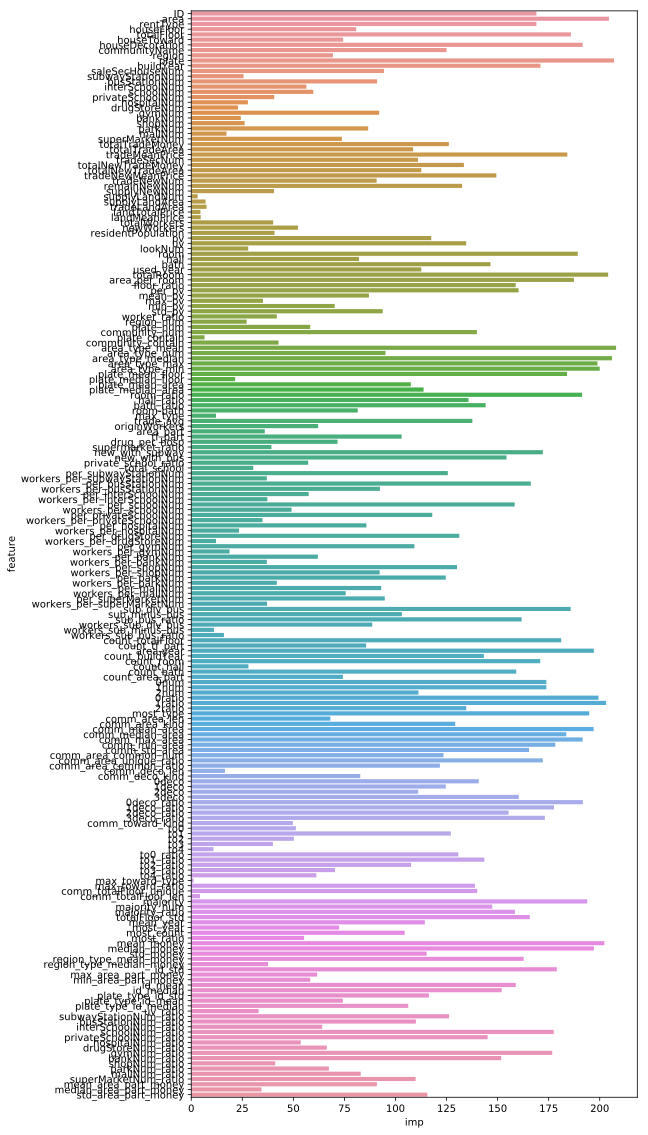

,feature,imp0,imp1,imp2,imp3,imp4,imp5,imp6,imp7,imp8,imp9,imp,std
64,area_type_mean,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.000,0.000000
9,plate,207.0,207.0,207.0,207.0,207.0,207.0,207.0,207.0,207.0,207.0,207.000,0.000000
66,area_type_median,206.0,206.0,206.0,206.0,206.0,206.0,206.0,206.0,206.0,206.0,206.000,0.000000
1,area,204.0,205.0,205.0,204.0,205.0,205.0,204.0,204.0,204.0,205.0,204.500,0.500000
50,totalRoom,205.0,203.0,203.0,205.0,203.0,204.0,205.0,205.0,205.0,203.0,204.125,0.927025
132,1ratio,203.0,204.0,204.0,203.0,204.0,203.0,202.0,202.0,202.0,202.0,203.125,0.780625
178,mean_money,202.0,202.0,202.0,202.0,202.0,202.0,203.0,203.0,203.0,204.0,202.250,0.433013
68,area_type_min,201.0,201.0,198.0,199.0,201.0,201.0,199.0,200.0,201.0,195.0,200.000,1.118034
131,0ratio,197.0,200.0,200.0,200.0,200.0,200.0,200.0,198.0,199.0,198.0,199.375,1.111024
67,area_type_max,196.0,199.0,201.0,201.0,196.0,196.0,201.0,201.0,198.0,201.0,198.875,2.315032


In [34]:
for col in fi_df.columns:
    if 'imp' in col:
        fi_df[col] = fi_df[col].rank()

fi_df['imp'] = np.mean(fi_df[fi_df.columns[1: 9]], axis=1)
fi_df['std'] = np.std(fi_df[fi_df.columns[1: 9]], axis=1)
plt.figure(figsize=(8, 20))
# fi_df['imp'].plot(kind='bar',)
sns.barplot(data=fi_df, x='imp', y='feature')
plt.show()
fi_df.sort_values('imp', ascending=False)
# fi_df

In [38]:
train.loc[train['ID'].isin(out_list)]

,ID,area,rentType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,region,plate,buildYear,saleSecHouseNum,subwayStationNum,busStationNum,interSchoolNum,schoolNum,privateSchoolNum,hospitalNum,drugStoreNum,gymNum,bankNum,shopNum,parkNum,mallNum,superMarketNum,totalTradeMoney,totalTradeArea,tradeMeanPrice,tradeSecNum,totalNewTradeMoney,totalNewTradeArea,tradeNewMeanPrice,tradeNewNum,remainNewNum,supplyNewNum,supplyLandNum,supplyLandArea,tradeLandNum,tradeLandArea,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney,type,room,hall,bath,trade_month,season,totalRoom,area_per_room,floor_ratio,per_pv,mean_pv,max_pv,min_pv,std_pv,worker_ratio,plate_mean,region_mean,plate_median,region_median,region_num,plate_num,community_num,plate_contain,community_contain,plate_mean_floor,plate_median_floor,plate_mean_area,plate_median_area,room_ratio,hall_ratio,bath_ratio,room-bath,max_type,trade_avg,originWorkers,area_part,tf_part,area_type_mean,area_type_median,per_subwayStationNum,workers_per_subwayStationNum,per_busStationNum,workers_per_busStationNum,per_interSchoolNum,workers_per_interSchoolNum,per_schoolNum,workers_per_schoolNum,per_privateSchoolNum,workers_per_privateSchoolNum,per_hospitalNum,workers_per_hospitalNum,per_drugStoreNum,workers_per_drugStoreNum,per_gymNum,workers_per_gymNum,per_bankNum,workers_per_bankNum,per_shopNum,workers_per_shopNum,per_parkNum,workers_per_parkNum,per_mallNum,workers_per_mallNum,per_superMarketNum,workers_per_superMarketNum,sub_div_bus,sub_minus_bus,sub_bus_ratio,workers_sub_div_bus,workers_sub_minus_bus,workers_sub_bus_ratio,count_totalFloor,count_tf_part,used_year,area-year,count_buildYear,count_room,count_hall,count_bath,count_area_part,drug_per_hosp,supermarket_ratio,new_with_subway,new_with_bus,private_school_ratio,total_school,0num,1num,2num,0ratio,1ratio,2ratio,most_type,comm_area_len,comm_area_kind,comm_mean_area,comm_median_area,comm_max_area,comm_min_area,comm_std_area,comm_area_common_num,comm_area_unique_ratio,comm_area_common_ratio,comm_deco_len,comm_deco_kind,0deco,1deco,2deco,3deco,0deco_ratio,1deco_ratio,2deco_ratio,3deco_ratio,comm_toward_kind,to0,to1,to2,to3,to4,to0_ratio,to1_ratio,to2_ratio,to3_ratio,to4_ratio,max_toward_type,max_toward_ratio,comm_totalFloor_unique,comm_totalFloor_len,majority,majority_num,majority_ratio,totalFloor_std,mean_year,most_year,most_count,most_ratio,money_per_area,mean_money,median_money,std_money,region_type_mean_money,region_type_median_money,money_for_room,id_std,id_mean,id_median,plate_type_id_std,plate_type_id_mean,plate_type_id_median,trade_sec_avg_area,trade_sec_avg_money,total_new_num,new_ratio,remain_ratio,new_over_remain,is_supply_new,trade_new_avg_area,trade_new_avg_money,trade_land_ratio,uv_ratio,subwayStationNum_ratio,busStationNum_ratio,interSchoolNum_ratio,schoolNum_ratio,privateSchoolNum_ratio,hospitalNum_ratio,drugStoreNum_ratio,gymNum_ratio,bankNum_ratio,shopNum_ratio,parkNum_ratio,mallNum_ratio,superMarketNum_ratio
343,100107357,96.00,1,1,11,0,0,3863,12,13,2008.0,0,4,72,2,64,9,8,34,32,53,223,7,1,56,670880000,13310.00,50404.20736,250,0,0,0.000000,0,7,0,0,0.00,0,0.0,0,0.000000,41503,0,301635,31739.0,4539.0,0,2018/5/22,15000.0,1,1,1,1,5,2,3,32.000000,6.0,6.992509,18139.0,31739.0,4539.0,13600.0,0.137593,5014.326087,5534.830671,4200.0,4350.0,3628,890,4,5,88,8.942697,6.0,51.381573,42.445,0.333333,0.333333,0.333333,0,0,53.027888,41503,4,2,6778.306994,5500.0,60327.000000,8300.600000,4131.986301,568.534247,100545.000000,13834.333333,4640.538462,638.507692,30163.500000,4150.300000,33515.000000,4611.444444,8618.142857,1185.800000,9140.454545,1257.666667,5585.833333,768.574074,1346.584821,185.281250,37704.375000,5187.875000,150817.500000,20751.500000,5291.842105,728.122807,14.600000,56195.013699,0.931507,14.600000,7732.065753,0.931507,3002,5301,10.0,8.727273,1958,19551,26250,38011,7161,3.777778,0.251121,0.454545,6.545455,0.200000,73,2,2,0,0.500000,0.500000,0.000000,0,4,4,77.945000,75.390

In [36]:
train_sub['label'] = train['tradeMoney']
train_sub['mean'] = np.mean(train_sub[train_sub.columns[1: 11]], axis=1)
train_sub['median'] = np.median(train_sub[train_sub.columns[1: 11]], axis=1)
train_sub['int_median'] = round(train_sub['median'])
# train_sub['is_co'] = [1 if area <= 20 else 0 for area in train['area']]
# train_sub['median'] = [median*1.1 if is_co == 1 else median for is_co, median in np.array(train_sub[['is_co', 'median']])]
train_sub['mean_error'] = train_sub['label'] - train_sub['mean']
train_sub['median_error'] = train_sub['label'] - train_sub['median']
train_sub['median_perc_error'] = abs(train_sub['median_error'] / train_sub['label'])
train_sub['int_median_error'] = train_sub['label'] - train_sub['int_median']
train_sub['rank'] = abs(train_sub['median_error']).rank(pct=True)
print('mean score: ', 1 - np.sum(np.power(train_sub['mean'] - train_sub['label'], 2)) / np.sum(np.power(train_sub['label'] - np.mean(train_sub['label']), 2)))
print('median score: ', 1 - np.sum(np.power(train_sub['median'] - train_sub['label'], 2)) / np.sum(np.power(train_sub['label'] - np.mean(train_sub['label']), 2)))
print('int_median score: ', 1 - np.sum(np.power(train_sub['int_median'] - train_sub['label'], 2)) / np.sum(np.power(train_sub['label'] - np.mean(train_sub['label']), 2)))
display(train_sub.sort_values('rank', ascending=False).head(50))
out_list = train_sub.sort_values('rank', ascending=False)['ID'].iloc[: 100].tolist()
# display(train_sub.sort_values('median_error'))
# plt.figure(figsize=(8, 8))
# train_sub['mean_error'].hist(bins=100)
# train_sub['median_error'].hist(bins=100)
# plt.scatter(x=train_sub['label'], y=abs(train_sub['median_error']) / train_sub['label'])

mean score:  0.980112863093
median score:  0.982107426778
int_median score:  0.982107462602


,ID,pred0,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,label,mean,median,int_median,mean_error,median_error,median_perc_error,int_median_error,rank
40300,100069036,6510.175642,6560.979223,7700.755655,8105.326413,7385.553512,6467.507335,8423.007544,8714.187164,7722.978015,1889.634845,13500.0,6948.010535,7543.154583,7543.0,6551.989465,5956.845417,0.441248,5957.0,1.000000
21428,100090570,15053.092815,15060.525118,15866.269011,16554.839085,15822.671025,10233.705619,16395.778344,16831.186961,16037.345180,16413.694232,20000.0,15426.910739,15951.807096,15952.0,4573.089261,4048.192904,0.202410,4048.0,0.999976
946,100150584,3963.846896,5458.814678,6012.982183,6233.957816,5676.857980,5587.670766,6128.301987,6286.326993,5946.778210,5991.693573,10000.0,5728.723108,5969.235892,5969.0,4271.276892,4030.764108,0.403076,4031.0,0.999951
26629,100060167,7975.002936,7786.425481,7212.062054,6820.086726,7642.793120,7785.608863,9531.939294,6693.149880,7100.622171,6902.634300,3500.0,7545.032482,7427.427587,7427.0,-4045.032482,-3927.427587,1.122122,-3927.0,0.999927
21333,100090924,17738.033249,17735.191221,18637.617699,18458.847967,18554.965266,14936.268160,18334.022202,18266.424895,17975.920568,18404.820437,22000.0,17904.211166,18300.223549,18300.0,4095.788834,3699.776451,0.168172,3700.0,0.999902
32315,100028167,16567.154039,17135.391321,17593.964079,17777.647072,17081.346549,16840.534024,18876.837384,13737.714817,17818.300933,17847.820974,21000.0,17127.671119,17364.677700,17365.0,3872.328881,3635.322300,0.173111,3635.0,0.999878
30738,100036712,20129.263468,19964.501413,19876.602964,19893.466066,19865.423957,19917.921697,19920.197355,22485.280513,19660.238863,18674.337208,16500.0,20038.723351,19905.693882,19906.0,-3538.723351,-3405.693882,0.206406,-3406.0,0.999853
29741,100042739,9689.806586,9408.175444,9114.950029,8902.539990,9293.753673,9643.860460,8429.359697,12438.490560,9101.376614,8964.524780,5800.0,9498.683783,9204.351851,9204.0,-3698.683783,-3404.351851,0.586957,-3404.0,0.999829
19856,100100012,6732.600889,6745.502252,6325.399812,5679.535295,9235.630291,6851.373302,5902.369714,5742.513929,6096.391248,6134.381541,2900.0,6544.569827,6229.890676,6230.0,-3644.569827,-3329.890676,1.148238,-3330.0,0.999804
18970,100105848,3477.915890,3540.333383,3659.240940,3823.234158,3224.736770,3528.144528,3795.421009,3868.256440,3682.828864,3767.281954,7000.0,3636.739394,3671.034902,3671.0,3363.260606,3328.965098,0.475566,3329.0,0.999780


In [ ]:
for i in np.linspace(4, 100, 25):
    det = train_sub[(train_sub['label']>= np.percentile(train_sub['label'], i-4.0)) & (train_sub['label'] < np.percentile(train_sub['label'], i))]
    print(i, '\t', np.percentile(train_sub['label'], i-4.0), '-', np.percentile(train_sub['label'], i), \
          round(abs(det['median_error']).mean(), 4), round(abs(det['median_error']).mean() / np.mean(det['label']), 4))

In [35]:
sub1 = sub
sub1
# cv_dict['0.9375_0.9375'] = 0.9080

,ID,pred0,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9
40650,100000079,4679.987591,4730.039507,4743.559490,4766.121716,4453.744798,4316.375518,4319.810151,4717.430093,4891.533713,4991.231944
40651,100000138,4821.400118,4910.192420,4885.795335,4852.915589,4793.237192,4880.494139,4761.363268,5017.176947,4872.724656,5028.629369
40652,100000192,6047.554587,6039.844998,6033.899779,5862.877637,5970.241926,5996.009606,6023.270057,5963.758070,5730.221984,6068.274373
40653,100000200,3667.944605,3620.786050,3732.874983,3761.484420,3717.485263,3651.116349,3699.018434,3718.677945,3812.411474,3723.835780
40654,100000430,4477.177320,4383.121542,4395.843203,4387.695906,4396.347850,4372.194156,4343.225639,4468.055420,4453.825313,4307.267482
40655,100000436,3602.176425,3461.602792,3439.000374,3415.633700,3490.897989,3550.301301,3482.307482,3647.819730,3451.325832,3280.789936
40656,100000510,2445.479700,2366.980324,2306.970114,2297.589315,2357.373106,2368.555461,2333.732905,2473.124723,2494.831134,2287.154477
40657,100000567,2781.892220,2569.763130,2578.771733,2580.366396,2601.288101,2622.652377,2604.532622,2568.786786,2606.178382,2526.925091
40658,100000724,5575.254604,5433.888637,5487.527224,5515.288379,5485.732057,5476.921455,5484.779737,5589.729417,5502.865985,5538.811040
40659,100000811,3672.152696,3953.825633,3919.365333,3822.408735,3881.133561,3974.665026,3933.918073,3780.850988,3994.949290,4365.841144


In [37]:
sub2 = sub
sub2.columns = ['ID', 'pred10', 'pred11', 'pred12', 'pred13', 'pred14', 'pred15', 'pred16',
       'pred17', 'pred18', 'pred19']

In [51]:
sub3 = sub
sub3.columns = ['ID', 'pred20', 'pred22', 'pred22', 'pred23', 'pred24', 'pred25', 'pred26',
       'pred27', 'pred28', 'pred29']

In [38]:
sub = sub1.merge(sub2, how='left', on=['ID'])#.merge(sub3, how='left', on=['ID'])
sub

,ID,pred0,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,pred10,pred11,pred12,pred13,pred14,pred15,pred16,pred17,pred18,pred19
0,100000079,4679.987591,4730.039507,4743.559490,4766.121716,4453.744798,4316.375518,4319.810151,4717.430093,4891.533713,4991.231944,4700.727127,4716.579178,4761.100729,4693.393339,4424.829127,4307.944502,4331.032672,4704.235229,4891.703239,4882.408331
1,100000138,4821.400118,4910.192420,4885.795335,4852.915589,4793.237192,4880.494139,4761.363268,5017.176947,4872.724656,5028.629369,4854.496160,4885.349730,4899.737007,4822.845804,4808.854874,4873.241346,4881.956472,5060.016950,4916.317891,5028.139168
2,100000192,6047.554587,6039.844998,6033.899779,5862.877637,5970.241926,5996.009606,6023.270057,5963.758070,5730.221984,6068.274373,6138.458418,6078.066963,6065.482165,6013.622178,5955.419760,5953.223579,6039.162587,5937.611768,5879.298230,6127.850818
3,100000200,3667.944605,3620.786050,3732.874983,3761.484420,3717.485263,3651.116349,3699.018434,3718.677945,3812.411474,3723.835780,3672.350488,3662.640393,3799.992593,3725.383136,3710.980293,3679.508089,3696.998292,3688.425131,3760.698592,3670.801555
4,100000430,4477.177320,4383.121542,4395.843203,4387.695906,4396.347850,4372.194156,4343.225639,4468.055420,4453.825313,4307.267482,4458.504465,4364.945629,4434.386178,4404.399174,4414.409714,4420.404317,4306.091798,4451.571747,4507.297761,4258.127989
5,100000436,3602.176425,3461.602792,3439.000374,3415.633700,3490.897989,3550.301301,3482.307482,3647.819730,3451.325832,3280.789936,3631.572284,3414.959995,3426.118729,3388.436427,3467.033273,3437.614015,3429.774246,3627.279065,3542.067898,3318.592501
6,100000510,2445.479700,2366.980324,2306.970114,2297.589315,2357.373106,2368.555461,2333.732905,2473.124723,2494.831134,2287.154477,2402.543275,2353.677109,2303.056474,2244.196679,2341.236408,2394.995952,2332.414744,2469.270057,2459.730258,2216.417115
7,100000567,2781.892220,2569.763130,2578.771733,2580.366396,2601.288101,2622.652377,2604.532622,2568.786786,2606.178382,2526.925091,2766.013413,2591.058694,2558.733526,2625.630013,2597.467962,2564.726753,2579.275086,2537.887882,2627.376496,2561.011626
8,100000724,5575.254604,5433.888637,5487.527224,5515.288379,5485.732057,5476.921455,5484.779737,5589.729417,5502.865985,5538.811040,5623.966323,5453.884298,5498.928850,5542.133579,5511.316198,5499.027668,5469.846178,5586.560803,5492.612394,5579.322603
9,100000811,3672.152696,3953.825633,3919.365333,3822.408735,3881.133561,3974.665026,3933.918073,3780.850988,3994.949290,4365.841144,3678.196875,3869.852127,3844.509879,3842.436657,3966.434258,3910.885338,3916.287073,3881.211728,3866.482339,4217.883610


In [39]:
sub['pred'] = np.median(sub[sub.columns[1: 21]], axis=1)
sub[['pred']].to_csv('05_31_2.csv', index=False, header=False)

In [27]:
train_cols = ['area', 'rentType', 'houseFloor', 'totalFloor', 'houseToward',
       'houseDecoration', 'communityName', 'region', 'plate', 'buildYear',
       'saleSecHouseNum', 'subwayStationNum', 'busStationNum',
       'interSchoolNum', 'schoolNum', 'privateSchoolNum', 'hospitalNum',
       'drugStoreNum', 'gymNum', 'bankNum', 'shopNum', 'parkNum', 'mallNum',
       'superMarketNum', 'totalTradeMoney', 'totalTradeArea', 'tradeMeanPrice',
       'tradeSecNum', 'totalNewTradeMoney', 'totalNewTradeArea',
       'tradeNewMeanPrice', 'tradeNewNum', 'remainNewNum', 'supplyNewNum',
       'supplyLandNum', 'supplyLandArea', 'tradeLandArea',
       'landTotalPrice', 'landMeanPrice', 'totalWorkers', 'newWorkers',
       'residentPopulation', 'pv', 'uv', 'lookNum', 'room', 'hall', 'bath', 'used_year', 'totalRoom',
       'area_per_room', 'floor_ratio', 'per_pv', 'mean_pv', 'max_pv', 'min_pv',
       'std_pv', 'worker_ratio', 'region_num', 'plate_num', 'community_num',
       'plate_contain', 'community_contain', 'area_type_mean',
       'plate_mean_floor', 'plate_median_floor', 'plate_mean_area',
       'plate_median_area', 'area-year', 'room_ratio', 'hall_ratio',
       'bath_ratio', 'room-bath', 'trade_avg', 'originWorkers',
       'area_part', 'tf_part', 'drug_per_hosp',
       'supermarket_ratio', 'new_with_subway', 'new_with_bus',
       'private_school_ratio', 'total_school', 'per_subwayStationNum',
       'per_busStationNum', 'per_interSchoolNum', 'per_schoolNum',
       'per_privateSchoolNum', 'per_hospitalNum', 'per_drugStoreNum',
       'per_gymNum', 'per_bankNum', 'per_shopNum', 'per_parkNum',
       'per_mallNum', 'per_superMarketNum', 'sub_over_bus', 'count_totalFloor',
       'count_buildYear', 'count_room', 'count_hall', 'count_bath',
       'count_area_part', 'count_tf_part', '0num', '1num', '2num', '0ratio',
       '1ratio', '2ratio', 'comm_area_len', 'comm_area_kind', 'comm_mean_area',
       'comm_median_area', 'comm_max_area', 'comm_min_area', 'comm_std_area',
       'comm_area_common_num', 'comm_area_unique_ratio',
       'comm_area_common_ratio', 'comm_deco_len', 'comm_deco_kind', '0deco',
       '1deco', '2deco', '3deco', '0deco_ratio', '1deco_ratio', '2deco_ratio',
       '3deco_ratio', 'comm_toward_kind', 'to0', 'to1', 'to2', 'to3', 'to4',
       'to0_ratio', 'to1_ratio', 'to2_ratio', 'to3_ratio', 'to4_ratio',
       'max_toward_ratio', 'comm_totalFloor_unique',
       'comm_totalFloor_len', 'majority', 'majority_num', 'majority_ratio',
       'totalFloor_std', 'mean_money', 'median_money', 'std_money', 'plate_type_mean_money',
       'plate_type_median_money', 'region_type_mean_money']